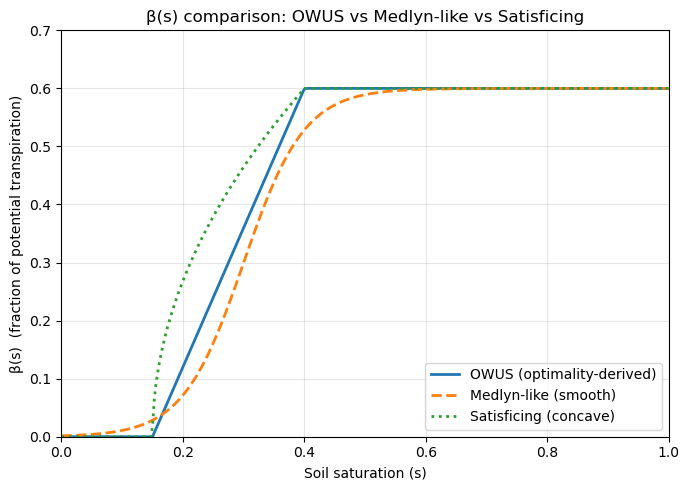

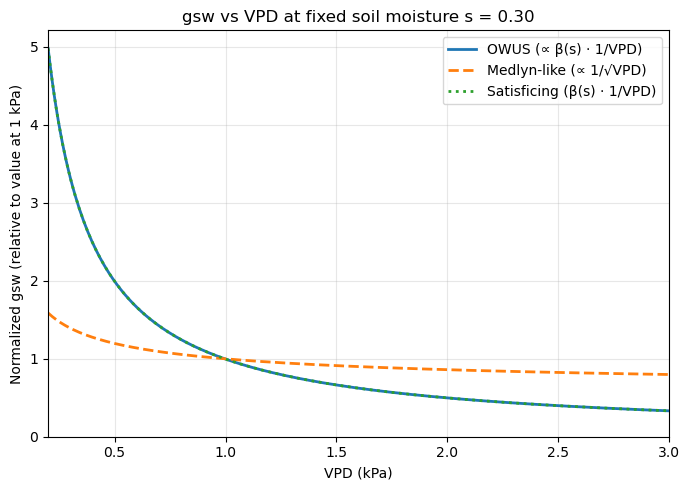

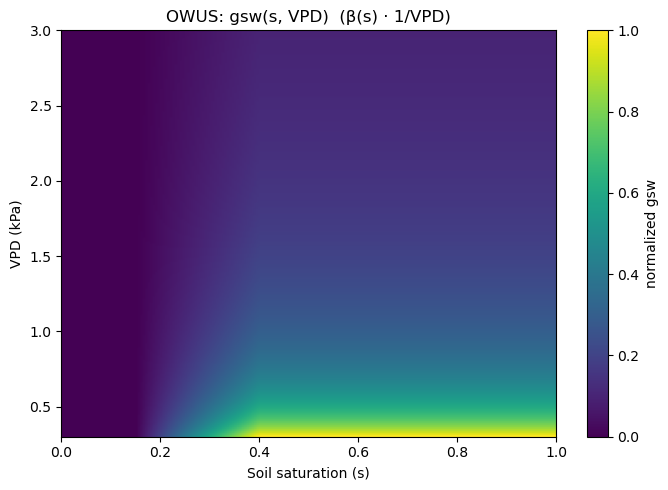

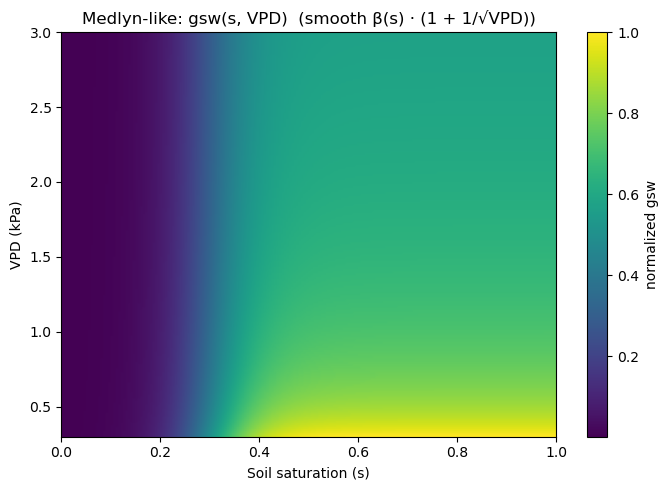

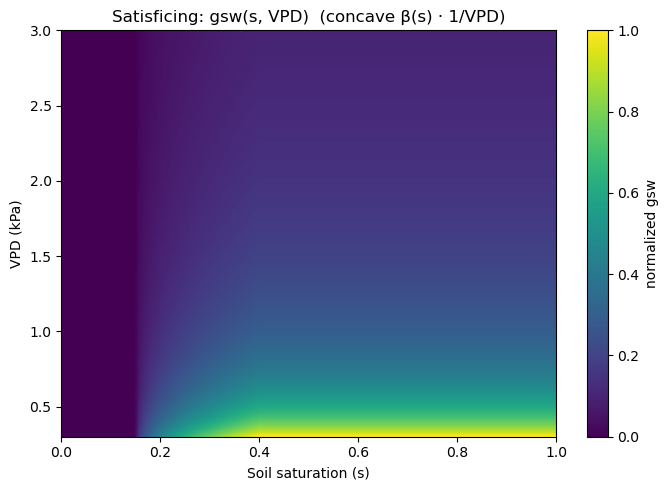

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# =========================
# Tunable parameters
# =========================
# Soil saturation thresholds & well-watered plateau for OWUS/satisficing
fww    = 0.6     # well-watered transpiration fraction (plateau)
s_star = 0.4     # onset of stress
s_w    = 0.15    # shutoff

# Atmospheric / scaling terms (illustrative)
P_air_kPa = 101.325    # kPa
E0_scale  = 3.5e-3     # m/day (just a scale factor for demonstration)

# Medlyn-like constants for illustrative scaling (qualitative)
g0 = 0.02
K  = 0.2
g1 = 1.0

# =========================
# Helper functions
# =========================
def beta_owus(s, fww, s_star, s_w):
    """OWUS piecewise-linear β(s): 0 below s_w, linear to s_star, flat at fww."""
    s = np.asarray(s)
    out = np.zeros_like(s, dtype=float)
    mid = (s > s_w) & (s <= s_star)
    hi  = s > s_star
    out[mid] = fww * (s[mid] - s_w) / max(s_star - s_w, 1e-12)
    out[hi]  = fww
    return out

def beta_satisficing(s, fww, s_star, s_w):
    """A concave (‘good-enough’) decline in the stress region."""
    s = np.asarray(s)
    out = np.zeros_like(s, dtype=float)
    mid = (s > s_w) & (s <= s_star)
    hi  = s > s_star
    # concave: exponent < 1
    out[mid] = fww * ((s[mid] - s_w) / max(s_star - s_w, 1e-12))**0.5
    out[hi]  = fww
    return out

def beta_medlyn_like(s, fww, center=0.3, sharp=20.0):
    """Smooth logistic proxy for a moisture-stress factor."""
    s = np.asarray(s)
    return fww / (1.0 + np.exp(-sharp * (s - center)))

def normalize_at(curve, x, x0=1.0):
    """Normalize y(x) so y(x0) == 1 (use nearest sample)."""
    i0 = int(np.argmin(np.abs(x - x0)))
    denom = curve[i0] if curve[i0] != 0 else 1.0
    return curve / denom

# =========================
# 1) β(s) comparison plot
# =========================
def plot_beta_comparison():
    s = np.linspace(0, 1, 400)
    b_ow = beta_owus(s, fww, s_star, s_w)
    b_md = beta_medlyn_like(s, fww, center=0.3, sharp=20.0)
    b_sa = beta_satisficing(s, fww, s_star, s_w)

    plt.figure(figsize=(7,5))
    plt.plot(s, b_ow, linewidth=2, label="OWUS (optimality-derived)")
    plt.plot(s, b_md, linewidth=2, linestyle="--", label="Medlyn-like (smooth)")
    plt.plot(s, b_sa, linewidth=2, linestyle=":", label="Satisficing (concave)")
    plt.xlabel("Soil saturation (s)")
    plt.ylabel("β(s)  (fraction of potential transpiration)")
    plt.title("β(s) comparison: OWUS vs Medlyn-like vs Satisficing")
    plt.grid(alpha=0.3)
    plt.ylim(0, max(fww*1.15, 0.7))
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()
    #plt.savefig("beta_comparison.png", dpi=200)
    plt.show()

# ======================================
# 2) gsw vs VPD at fixed soil moisture
# ======================================
def plot_gsw_vs_vpd_at_fixed_s(s_fixed=0.30):
    D = np.linspace(0.2, 3.0, 300)  # VPD in kPa

    # Atmospheric scaling
    # OWUS/satisficing: gsw ∝ β(s) * E0 * (P / VPD)
    b_ow = beta_owus(s_fixed, fww, s_star, s_w)
    b_sa = beta_satisficing(s_fixed, fww, s_star, s_w)
    gs_ow = b_ow * E0_scale * (P_air_kPa / D)
    gs_sa = b_sa * E0_scale * (P_air_kPa / D)

    # Medlyn-like (qualitative): gsw ≈ g0 + K * (1 + g1/√VPD), then a smooth β(s) factor
    # For a pure VPD slice, we’ll just compare atmospheric scalings;
    # if desired, multiply by beta_medlyn_like(s_fixed, fww) as an overall factor.
    gs_md = g0 + K * (1.0 + g1 / np.sqrt(D))

    # Normalize for visual comparison at D = 1 kPa
    gs_ow_n = normalize_at(gs_ow, D, x0=1.0)
    gs_sa_n = normalize_at(gs_sa, D, x0=1.0)
    gs_md_n = normalize_at(gs_md, D, x0=1.0)

    plt.figure(figsize=(7,5))
    plt.plot(D, gs_ow_n, linewidth=2, label="OWUS (∝ β(s) · 1/VPD)")
    plt.plot(D, gs_md_n, linewidth=2, linestyle="--", label="Medlyn-like (∝ 1/√VPD)")
    plt.plot(D, gs_sa_n, linewidth=2, linestyle=":", label="Satisficing (β(s) · 1/VPD)")
    plt.xlabel("VPD (kPa)")
    plt.ylabel("Normalized gsw (relative to value at 1 kPa)")
    plt.title(f"gsw vs VPD at fixed soil moisture s = {s_fixed:.2f}")
    plt.grid(alpha=0.3)
    plt.xlim(D.min(), D.max())
    plt.ylim(0, None)
    plt.legend()
    plt.tight_layout()
    #plt.savefig("gsw_vs_vpd_at_fixed_s.png", dpi=200)
    plt.show()

# =========================================
# 3) Heatmaps: gsw(s, VPD) for all closures
# =========================================
def plot_heatmaps():
    s = np.linspace(0.0, 1.0, 200)
    D = np.linspace(0.3, 3.0, 200)
    S, Dm = np.meshgrid(s, D)

    # β(s) fields
    B_ow = beta_owus(S, fww, s_star, s_w)
    B_sa = beta_satisficing(S, fww, s_star, s_w)
    B_md = beta_medlyn_like(S, fww, center=0.3, sharp=20.0)

    # gs formulations (qualitative scalings)
    gs_ow = B_ow * E0_scale * (P_air_kPa / Dm)             # β(s) · 1/VPD
    gs_sa = B_sa * E0_scale * (P_air_kPa / Dm)             # β(s) · 1/VPD
    gs_md = (g0 + K * (1.0 + g1 / np.sqrt(Dm))) * B_md     # smooth β(s) · (1 + 1/√VPD)

    def norm_grid(G):
        M = np.nanmax(G)
        return G / M if M > 0 else G

    G_ow = norm_grid(gs_ow)
    G_md = norm_grid(gs_md)
    G_sa = norm_grid(gs_sa)

    # OWUS
    plt.figure(figsize=(7,5))
    im1 = plt.imshow(G_ow, origin='lower', aspect='auto',
                     extent=[s.min(), s.max(), D.min(), D.max()])
    plt.colorbar(im1, label="normalized gsw")
    plt.xlabel("Soil saturation (s)")
    plt.ylabel("VPD (kPa)")
    plt.title("OWUS: gsw(s, VPD)  (β(s) · 1/VPD)")
    plt.tight_layout()
    #plt.savefig("heatmap_owus.png", dpi=200)
    plt.show()

    # Medlyn-like
    plt.figure(figsize=(7,5))
    im2 = plt.imshow(G_md, origin='lower', aspect='auto',
                     extent=[s.min(), s.max(), D.min(), D.max()])
    plt.colorbar(im2, label="normalized gsw")
    plt.xlabel("Soil saturation (s)")
    plt.ylabel("VPD (kPa)")
    plt.title("Medlyn-like: gsw(s, VPD)  (smooth β(s) · (1 + 1/√VPD))")
    plt.tight_layout()
    #plt.savefig("heatmap_medlyn_like.png", dpi=200)
    plt.show()

    # Satisficing
    plt.figure(figsize=(7,5))
    im3 = plt.imshow(G_sa, origin='lower', aspect='auto',
                     extent=[s.min(), s.max(), D.min(), D.max()])
    plt.colorbar(im3, label="normalized gsw")
    plt.xlabel("Soil saturation (s)")
    plt.ylabel("VPD (kPa)")
    plt.title("Satisficing: gsw(s, VPD)  (concave β(s) · 1/VPD)")
    plt.tight_layout()
    #plt.savefig("heatmap_satisficing.png", dpi=200)
    plt.show()

# =========================
# Run everything
# =========================
if __name__ == "__main__":
    plot_beta_comparison()
    plot_gsw_vs_vpd_at_fixed_s(s_fixed=0.30)
    plot_heatmaps()
